In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

## The objective

Take a bunch of base station locations and their sensitivity tables and find regions with coverage based on spreading factors

In [2]:
# sensitivity data for gateways
sensi_lorasim = pd.DataFrame(
        {7:{ 125:-126.5,  250:-124.25, 500:-120.75}, 
         8:{ 125:-127.25, 250:-126.75, 500:-124.0}, 
         9:{ 125:-131.25, 250:-128.25, 500:-127.5}, 
         10:{125:-132.75, 250:-130.25, 500:-128.75}, 
         11:{125:-134.5,  250:-132.75, 500:-128.75}, 
         12:{125:-135.25, 250:-133.25, 500:-132.25}}).transpose()

# log-distance model parameters
# log shadow model parameters
Ptx = 15 # in dBm

# gamma = 2.2394 # from campus test
gamma= 2.14949648 # from drive test

# d0 = 40.0 # in m
d0 = 40.0 # from drive tests

var = 0 # variance ignored for now. 

# Lpld0 = 127.41
# Lpld0 = 95.0038 # from campus test
Lpld0 = 98.0729471 # from drive test

estimatedL0 = 107.812891686 # from estimated correction to sensitivity values
GL = 0

# the sensitivity values have to be corrected to fit our noise levels
L0_correction =  estimatedL0 - Lpld0
sensi_1301 = sensi_lorasim + L0_correction

#
# span of the test space
#
X_min = -10000
X_max = 10000
Y_min = -10000
Y_max = 10000
nAxisPoints = 200 # use for final paper figure
# nAxisPoints = 100 # use for testing


x_range = np.linspace(2*X_min, 2*X_max, 2*nAxisPoints + 1)
y_range = np.linspace(2*Y_min, 2*Y_max, 2*nAxisPoints + 1)
Xgrid, Ygrid = np.meshgrid(x_range, y_range)

def combinedSNR(pos, BSloc, PTX):
    d = np.sqrt(np.sum((BSloc - pos)**2, axis=1))
    sum_idp = np.sum(d**(-gamma))
    return PTX - Lpld0 + 10*gamma*np.log10(d0) + 10*np.log10(sum_idp)

def independentSNR(pos, BSloc, PTX):
    d = np.sqrt(np.sum((BSloc - pos)**2))
    return PTX - Lpld0 + 10*gamma*np.log10(d0) - 10*gamma*np.log10(d)

def bestIndependentSNR(pos, BSloc, PTX):
    d = np.sqrt(np.sum((BSloc - pos)**2, axis=1))
    minD = np.amin(d)
    return PTX - Lpld0 + 10*gamma*np.log10(d0) - 10*gamma*np.log10(minD)

def computeMeshCombSNR(X, Y, BSloc, PTX):
    gridShape = X.shape
    d = np.empty(gridShape)
    for i in range(gridShape[0]):
        for j in range(gridShape[1]):
            d[i,j] = combinedSNR(np.array([X[i,j], Y[i,j]]), BSloc, PTX)
    return d

def computeMeshBestSNR(X, Y, BSloc, PTX):
    gridShape = X.shape
    d = np.empty(gridShape)
    for i in range(gridShape[0]):
        for j in range(gridShape[1]):
            d[i,j] = bestIndependentSNR(np.array([X[i,j], Y[i,j]]), BSloc, PTX)
    return d

def interestRegion(orig, improv, sf, bw):
    # region where original was detectable
    diffRegion = improv - orig
    maskedDiffRegion = np.ma.masked_where((orig > sensi_1301.loc[sf,bw]) | ((improv < sensi_1301.loc[sf,bw])), diffRegion)
    return maskedDiffRegion

def getBestSF(signalGrid):
    best = np.zeros(signalGrid.shape, dtype=int)
    for sf in range(12, 7-1, -1):
        best[signalGrid > sensi_1301.loc[sf, 125]] = sf
    return best

def getDRIncrease(bestSF, combSF):
    bestDR = 13 - bestSF
    bestDR[bestDR > 6] = 0 # mask invalid values (from no coverage regions)
    combDR = 13 - combSF
    combDR[bestDR > 6] = 0 # mask invalid values (from no coverage regions) 
    return combDR - bestDR

def increasedCoverage(bestSF, combSF):
    return float(np.count_nonzero(combSF >= 7))/float(np.count_nonzero(bestSF >= 7))
    
def getDRIncreaseInRange(bestSF, combSF):
    diffSF = bestSF - combSF # compute difference
    diffSF[bestSF < 7] = 0 # mask regions out of coverage
    coverageArea = float(np.count_nonzero(bestSF >= 7))
    step1 = float(np.count_nonzero(diffSF == 1))
    step2 = float(np.count_nonzero(diffSF == 2))
    step3 = float(np.count_nonzero(diffSF == 3))
    step4 = float(np.count_nonzero(diffSF == 4))
    step5 = float(np.count_nonzero(diffSF == 5))
    return (step1/coverageArea, step2/coverageArea, step3/coverageArea, step4/coverageArea, step5/coverageArea)

# campus gateways
# BS_loc = np.array([[-1, 1], # CIC
#                    [102.83, -102.83], # Wean
#                    [360.03, -263.07], # Tepper
#                    [215.52, 244.90]]) # Craig

# grid of 8
# BS_loc = np.array([[-2501, 7501],
#                    [7501, 7501],
#                    [-7501, 2501],
#                    [2501, 2501],
#                    [-2501, -2501],
#                    [7501, -2501],
#                    [-7501, -7501],
#                    [2501, -7501]])

# grid of 4
# BS_loc = np.array([[-4501, 4501], 
#                    [4501, 4501], 
#                    [-4501, -4501], 
#                    [4501, -4501]])



def plotIncreaseHeatmap(name, Xgrid, Ygrid, sigBest, sigComb, sfBest, sfComb, drDiff, showLegend=False):
    
    if name:
        filename = "{:s}_IncreaseHeatmap.pdf".format(name)
    
    # generates the heatmap of data rate improvements due to Charm vs LoRaWAN
    fig = plt.figure()

    # create custom colormap
    cmap = plt.cm.get_cmap("autumn_r")
    cmap.set_under("none")

    # draw contours
    contour = plt.contourf(Xgrid, Ygrid, drDiff, levels=[0.5,1.5,2.5,3.5,4.5], cmap=cmap, extend='min')
    plt.contour(Xgrid, Ygrid, sigBest, levels=[sensi_1301.loc[12,125]], colors='k', linestyles='dashed')
    plt.contourf(Xgrid, Ygrid, sigBest, levels=[sensi_1301.loc[12,125], np.inf], hatches=['..'], colors='none')
    plt.contour(Xgrid, Ygrid, sigComb, levels=[sensi_1301.loc[12,125]], colors='k', linestyles='solid')
    plt.contourf(Xgrid, Ygrid, sigComb, levels=[sensi_1301.loc[12,125], np.inf], hatches=['/'], colors='none')

    # gateway locations
    plt.plot(BS_loc[:,0], BS_loc[:,1], 'k^', markersize=10)

    # axis settings
    plt.xlabel("distance (km)")
    plt.ylabel("distance (km)")
    plt.xticks(np.linspace(X_min, X_max, 5), np.linspace(X_min/1000, X_max/1000, 5, dtype=int))
    plt.yticks(np.linspace(Y_min, Y_max, 5), np.linspace(Y_min/1000, Y_max/1000, 5, dtype=int))
    plt.xlim([X_min, X_max])
    plt.ylim([Y_min, Y_max])
    plt.axes().set_aspect('equal')
    plt.grid()

    if showLegend is True:
        # show colorbar
        cbaxes = fig.add_axes([0.925, 0.43, 0.03, 0.45]) 
        colorbar = plt.colorbar(contour, cax = cbaxes)
        colorbar.set_ticks([0.5,1,2,3,4])
        colorbar.ax.set_ylabel("Data rate\nincrease")
        colorbar.ax.set_yticklabels(["None","+1", "+2", "+3", "+4"])

        # create separate axes for legend, create fake artists and show legend
        legaxes = fig.add_axes([1.05, 0.25, 0.2, 0.2])
        legaxes.set_axis_off()
        lorawanHatch = mpatches.Patch(linestyle='dashed', hatch='..', facecolor='none', edgecolor= 'k', linewidth = 2, label="LoRaWAN\ncoverage")
        charmHatch = mpatches.Patch(linestyle='solid', hatch='/', facecolor='none', edgecolor='k', linewidth=2, label="Charm\ncoverage")
        gatewayLoc = mlines.Line2D([], [], color='k', marker='^', markersize=10, linestyle = 'none',label="Gateway")
        plt.legend(handles = [gatewayLoc, lorawanHatch, charmHatch], loc='upper right', handlelength=3,fontsize='small')
        
    if name:
        plt.savefig(filename, format='pdf', bbox_inches="tight")


def plotDatarate(name, Xgrid, Ygrid, signalLevel, sfLevel, showLegend = False):
    # generates heatmap of simulated data rates
    
    if name:
        filename = "{:s}_DatarateHeatmap.pdf".format(name)
        
    fig = plt.figure()
    plt.contour(Xgrid, Ygrid, signalLevel, levels=[sensi_1301.loc[12,125]], colors='k', linestyles='dashed')
    contour = plt.contourf(Xgrid, Ygrid, sfLevel, levels=[6.5,7.5,8.5,9.5,10.5,11.5,12.5], cmap=plt.cm.autumn)
    plt.plot(BS_loc[:,0], BS_loc[:,1], 'k^', markersize=10)
    plt.axes().set_aspect('equal')
    plt.xlabel("distance (km)")
    plt.ylabel("distance (km)")
    plt.xticks(np.linspace(X_min, X_max, 5), np.linspace(X_min/1000, X_max/1000, 5, dtype=int))
    plt.yticks(np.linspace(Y_min, Y_max, 5), np.linspace(Y_min/1000, Y_max/1000, 5, dtype=int))
    plt.xlim([X_min, X_max])
    plt.ylim([Y_min, Y_max])
    
    if showLegend is True:
        cbaxes = fig.add_axes([0.85, 0.1, 0.03, 0.75]) 
        colorbar = plt.colorbar(contour, cax = cbaxes)
        colorbar.set_ticks([7,8,9,10,11,12])
        colorbar.set_ticklabels([5470,3125,1760,980,540,295])
        colorbar.ax.set_ylabel("Data rate (bps)")
        
    if name:
        plt.savefig(filename, format='pdf', bbox_inches="tight")

def generatePlots(name, Xgrid, Ygrid, BS_loc, Ptx):
    
    # compute relevant data
    sigComb = computeMeshCombSNR(Xgrid, Ygrid, BS_loc, Ptx)
    sigBest = computeMeshBestSNR(Xgrid, Ygrid, BS_loc, Ptx)
    sfBest = getBestSF(sigBest)
    sfComb = getBestSF(sigComb)
    drDiff = getDRIncrease(sfBest, sfComb)

    print("increase in coverage area: {}".format(increasedCoverage(sfBest, sfComb)))
    print("DR increase in covered area: {}".format(getDRIncreaseInRange(sfBest, sfComb)))
    
    # setup plots
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    
    # generate plots
    
    if name:
        namePrefix = name
        lorawanPrefix = "{}_lorawan".format(name)
        charmPrefix = "{}_charm".format(name)
        nameWLegendPrefix = "{}_wLegend".format(name)
        lorawanWLegendPrefix = "{}_wLegend_lorawan".format(name)
        charmWLegendPrefix = "{}_wLegend_charm".format(name)
    else:
        namePrefix = None
        lorawanPrefix = None
        charmPrefix = None
        nameWLegendPrefix = None
        lorawanWLegendPrefix = None
        charmWLegendPrefix = None
    
    # LoRaWAN vs Charm comparison plot
    plotIncreaseHeatmap(namePrefix, Xgrid, Ygrid, sigBest, sigComb, sfBest, sfComb, drDiff, False)
    # LoRaWAN datarates
    plotDatarate(lorawanPrefix, Xgrid, Ygrid, sigBest, sfBest, False)
    # Charm datarates
    plotDatarate(charmPrefix, Xgrid, Ygrid, sigComb, sfComb, False)
    # LoRaWAN vs Charm comparison plot
    plotIncreaseHeatmap(nameWLegendPrefix, Xgrid, Ygrid, sigBest, sigComb, sfBest, sfComb, drDiff, True)
    # LoRaWAN datarates
    plotDatarate(lorawanWLegendPrefix, Xgrid, Ygrid, sigBest, sfBest, True)
    # Charm datarates
    plotDatarate(charmWLegendPrefix, Xgrid, Ygrid, sigComb, sfComb, True)

    # show output
    plt.show()

increase in coverage area: 1.9785596327707335
DR increase in covered area: (0.38822179304167714, 0.0, 0.0, 0.0, 0.0)


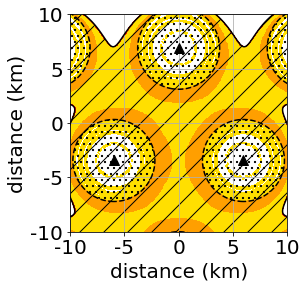

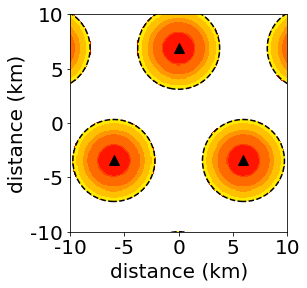

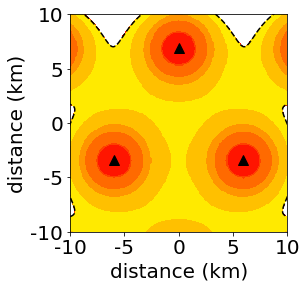

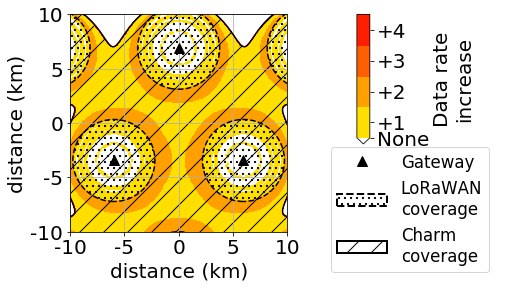

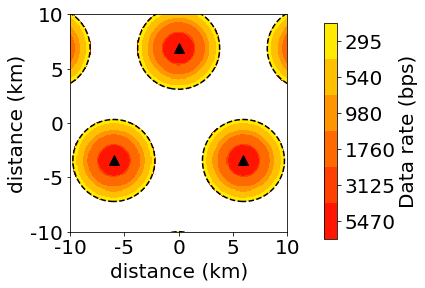

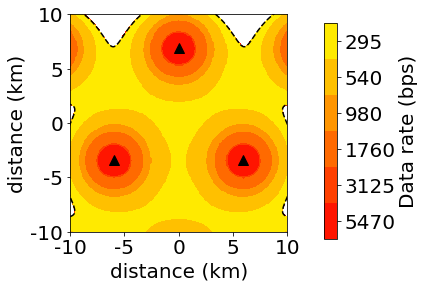

In [3]:
# sparsely placed gateways        
sep = 6881
BS_loc = np.array([[sep*np.cos(np.pi/2) - 2*sep*np.cos(np.pi/6), sep*np.sin(np.pi/2)],
                   [sep*np.cos(np.pi/2), sep*np.sin(np.pi/2)],
                   [sep*np.cos(np.pi/2) + 2*sep*np.cos(np.pi/6), sep*np.sin(np.pi/2)],
                   [sep*np.cos(-np.pi/6), sep*np.sin(-np.pi/6)],
                   [sep*np.cos(-5*np.pi/6), sep*np.sin(-5*np.pi/6)],
                   [sep*np.cos(np.pi/2) - 2*sep*np.cos(np.pi/6), sep*np.sin(-np.pi/2) - sep],
                   [sep*np.cos(-np.pi/2), sep*np.sin(-np.pi/2) - sep],
                   [sep*np.cos(np.pi/2) + 2*sep*np.cos(np.pi/6), sep*np.sin(-np.pi/2) - sep]])

generatePlots("sparse", Xgrid, Ygrid, BS_loc, Ptx)

increase in coverage area: 1.466071594032801
DR increase in covered area: (0.3533372455755629, 0.22309046545387157, 0.022608641937177626, 0.0, 0.0)


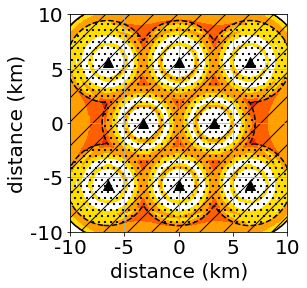

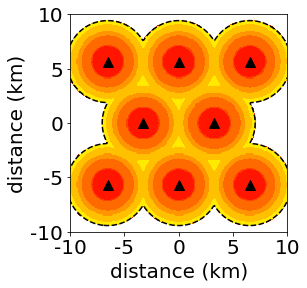

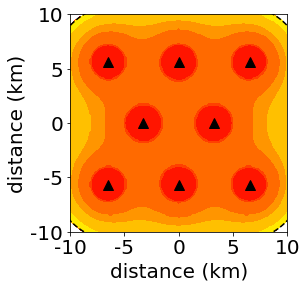

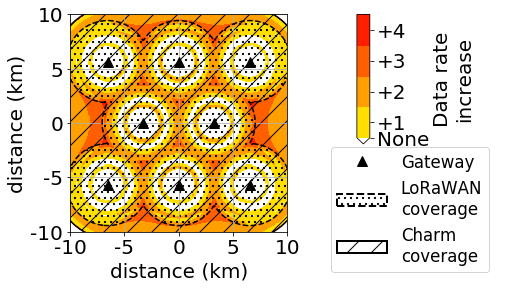

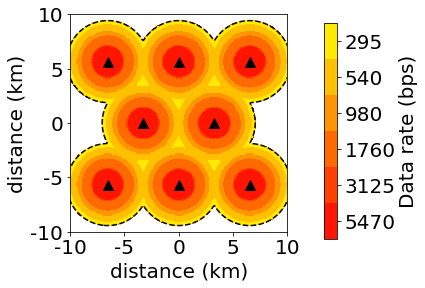

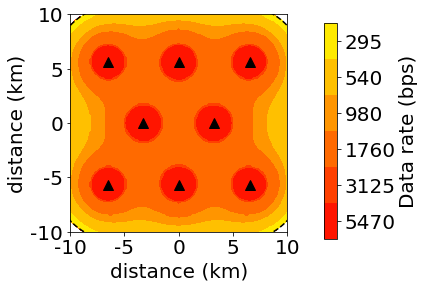

In [4]:
# dense cells
sep = 3770
BS_loc = np.array([[sep*np.cos(np.pi/2) - 2*sep*np.cos(np.pi/6), sep*np.sin(np.pi/2)-sep*np.sin(-np.pi/6)],
                   [sep*np.cos(np.pi/2), sep*np.sin(np.pi/2)-sep*np.sin(-np.pi/6)],
                   [sep*np.cos(np.pi/2) + 2*sep*np.cos(np.pi/6), sep*np.sin(np.pi/2)-sep*np.sin(-np.pi/6)],
                   [sep*np.cos(-np.pi/6), sep*np.sin(-np.pi/6)-sep*np.sin(-np.pi/6)],
                   [sep*np.cos(-5*np.pi/6), sep*np.sin(-5*np.pi/6)-sep*np.sin(-np.pi/6)],
                   [sep*np.cos(np.pi/2) - 2*sep*np.cos(np.pi/6), sep*np.sin(-np.pi/2) - sep-sep*np.sin(-np.pi/6)],
                   [sep*np.cos(-np.pi/2), sep*np.sin(-np.pi/2) - sep-sep*np.sin(-np.pi/6)],
                   [sep*np.cos(np.pi/2) + 2*sep*np.cos(np.pi/6), sep*np.sin(-np.pi/2) - sep-sep*np.sin(-np.pi/6)]])

generatePlots("dense", Xgrid, Ygrid, BS_loc, Ptx)

increase in coverage area: 1.7459782867105158
DR increase in covered area: (0.33703146049607735, 0.2582613519296299, 0.0348284333148427, 0.0, 0.0)


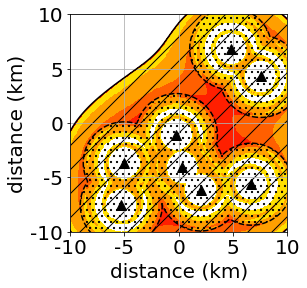

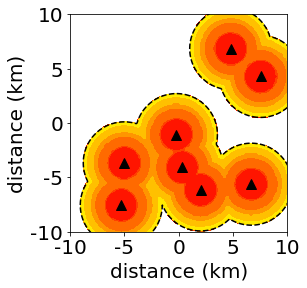

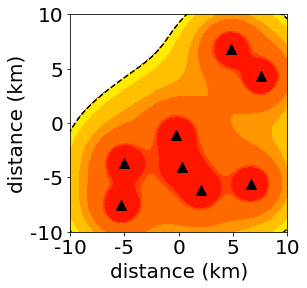

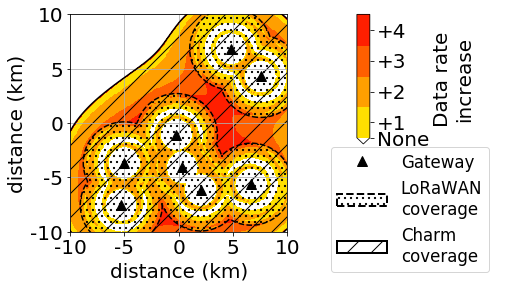

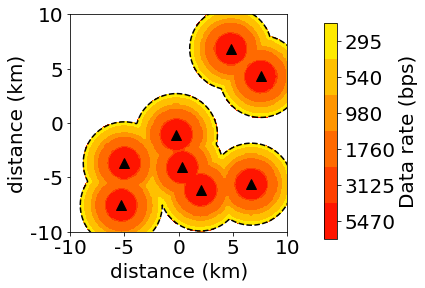

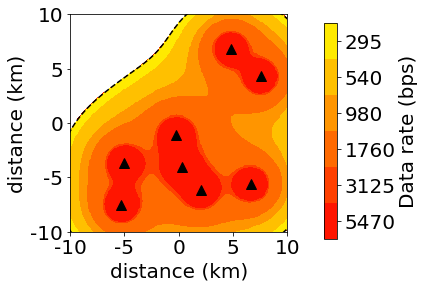

In [5]:
# random placement
def placeGatewayRandomly(nGW):
    loc = np.empty((nGW,2))
    loc[:,0] = np.random.uniform(0.9*X_min, 0.9*X_max, nGW)
    loc[:,1] = np.random.uniform(0.9*Y_min, 0.9*Y_max, nGW)
    return loc
np.random.seed(5) # seed 5 provides a nice placement for 8 gateways
BS_loc = placeGatewayRandomly(8)

generatePlots("random", Xgrid, Ygrid, BS_loc, Ptx)